In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import datasets

In [309]:
# Load data
dataset = pd.read_csv("./datasets/mobiles-wine-combined.csv")
dataset = dataset.sample(frac=1)
dataset.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
A                float64
B                float64
C                float64
D                float64
E                  int64
F                float64
G                float64
H                float64
I                float64
J                float64
K                float64
L                float64
M                  int64
Class_ID           int64
dtype: object

In [310]:
# features and labels
X = dataset.iloc[:, 0:33].values
y = dataset.iloc[:, 33].values

# Row normalization
# for i, x in enumerate(X):
#     minVal = np.min(x)
#     norm_x = x - minVal
#     maxVal = np.max(norm_x)
#     norm_x /= maxVal
#     X[i] = norm_x
    
# Column normalization
for i in range(X.shape[1]):
    x = X[:, i]
    minVal = np.min(x)
    norm_x = x - minVal
    maxVal = np.max(norm_x)
    norm_x /= maxVal
    X[:, i] = norm_x

## Clustering

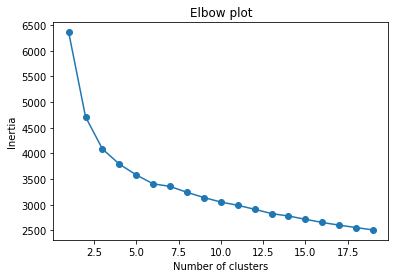

In [311]:
from sklearn.cluster import KMeans

X_l = list(X)

cluster_data = []
for i in range(0, len(X_l)):
    cluster_data.append(list(X_l[i]))
    
inertias = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster_data)
    inertias.append(kmeans.inertia_)
    
plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [312]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [313]:
dataset.shape

(2178, 34)

Number of clusters chosen to be two

In [314]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster_data)

kmeans_store = kmeans.labels_

In [315]:
clusters = [i for i in range(3)]
num_clusters = len(clusters)

## Training

In [316]:
cluster_partitions = [] # stores attributes of rows belonging to certain cluster in a dd list
cluster_indices = [] # stores indices of rows belonging to certain cluster in a dd list

for j in range(num_clusters):
    partition = []
    indices = []
    for i in range(X_train.shape[0]):
        if kmeans.labels_[i] == j:
            partition.append(X_train[i])
            indices.append(i)
            
    cluster_partitions.append(partition)
    cluster_indices.append(indices)

In [317]:
K_VALUES = [3,5,7,9,11,13,15,17,19]

# Finding best k per cluster
k_clusters = [0 for _ in range(num_clusters)]
for i in range(num_clusters):
    data = cluster_partitions[i]      # attribute rows belonging to cluster i
    label = clusters[i]
    most_count = [0 for _ in range(len(K_VALUES))]
    
    match = 0
    for test_point_index, test_point in enumerate(data):
        distances_dict = Counter()
        cluster_count = Counter()

        for index, train_point in enumerate(X_train):
            distances_dict[index] = np.sum(np.square(test_point - train_point))

        matched_k_list = []
        index = 0
        for K in K_VALUES:
            for point_index, point in distances_dict.most_common()[-(K + 1):-1]:
                cluster_count[y_train[point_index]] += 1

            if cluster_count.most_common(1)[0][0] == y_train[test_point_index]:
                matched_k_list.append(K)
                most_count[index] += 1
            index += 1

        
    # Taking the first best k value in case of ties
    maxpos = most_count.index(max(most_count))

    k_clusters[i] = K_VALUES[maxpos]               # ideal k value for the cluster

## Testing

In [318]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

test_iter = list(X_test)

final_acc = 0

total = len(X_test)

for j in clusters:
    index = len(X_train)
    num = 0
    test_points_in_cluster=[]
    test_y_in_cluster=[]
    for i in test_iter:
        if(kmeans_store[index] == j):     # check which test points belong to current cluster
            test_points_in_cluster.append(i)
            test_y_in_cluster.append(y[index])
            num += 1
        index += 1

    classifier = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)
    classifier.fit(X_train, y_train)
    
    test_points_in_cluster = np.array(test_points_in_cluster)
    test_y_in_cluster = np.array(test_y_in_cluster)

    y_pred = classifier.predict(test_points_in_cluster)
    
    ac = accuracy_score(test_y_in_cluster, y_pred)

    final_acc += (num / total) * ac  # create a separate model for each cluster and take a frequency weighted average in the end
    
print("Final Accuracy is", final_acc)

Final Accuracy is 0.4655963302752294


In [319]:
dataset.sample(frac=1)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,E,F,G,H,I,J,K,L,M,Class_ID
1117,1970,0,1.6,1,11,1,58,0.3,80,8,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,2
337,668,0,2.3,0,2,1,48,0.3,114,1,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,0
811,807,0,0.5,0,9,0,8,0.3,158,5,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,0
1025,1081,1,2.5,1,13,0,49,1.0,99,3,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,0
1542,1908,0,0.5,0,9,1,30,1.0,111,2,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,765,0,2.9,0,0,1,18,0.1,153,7,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,0
1854,1571,0,2.9,0,1,0,30,0.9,150,7,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,0
2067,0,0,0.0,0,0,0,0,0.0,0,0,...,78,2.11,2.0,0.27,1.04,4.68,1.12,3.48,510,5
1352,798,1,0.5,1,7,0,2,0.8,148,2,...,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0,2
